# Training ANN model on data

    Find best fill nan strategy: mean, median, drop, last value seen or 0

In [1]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

import keras
from keras.models import Sequential # to initialise the NN
from keras.layers import Dense # to create layers
from keras.layers import Dropout
from keras import initializers
import keras.optimizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [13]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# 2018 data
data = data.loc[data.index > 2018050000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan function
def fill_nan(method_):
    data.fillna(method_, inplace = True)
    return data

fillnan_range = [data.mean(), 
                 data.median(), 
                 'ffill',
                 0
                 ]

fillnan_label = ['Mean', 'Median', 'Last available', 'Zero', 'Drop']
means = []
std = []

for i in fillnan_range:
    data = fill_nan(i)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']

    # X = X.astype('float64')
    X = X.round(20)

    # divide data into train and test with 20% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.2, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    def regressor_tunning(n_hidden = 2, 
                      n_neurons = 30, 
                      optimizer = 'Adamax', 
                      kernel_initializer = "he_normal",
                      bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model

    tscv = TimeSeriesSplit(n_splits = 7)

    regressor = KerasRegressor(build_fn = regressor_tunning, batch_size = 10, epochs = 80)
    accuracies = sklearn.model_selection.cross_val_score(estimator = regressor,X = X_train, y = y_train, cv = tscv, n_jobs = -1)

    means.append(accuracies.mean())
    std.append(accuracies.std())

# drop nan method

data.dropna(inplace = True)

X = data.iloc[:, 0:15]
y = data.loc[:, 'Offers']

# X = X.astype('float64')
X = X.round(20)

# divide data into train and test with 20% test data
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.2, shuffle=False)

# feature scaling
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
    
def regressor_tunning(n_hidden = 2, 
                      n_neurons = 30, 
                      optimizer = 'Adamax', 
                      kernel_initializer = "he_normal",
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    model.add(Dense(units = n_neurons, input_dim = 15))
    model.add(keras.layers.LeakyReLU(alpha = 0.2))
    model.add(Dropout(rate = 0.1))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
    model.add(Dense(units = 1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
    return model

tscv = TimeSeriesSplit(n_splits = 7)

regressor = KerasRegressor(build_fn = regressor_tunning, batch_size = 10, epochs = 80)
accuracies = sklearn.model_selection.cross_val_score(estimator = regressor,X = X_train, y = y_train, cv = tscv, n_jobs = -1)

means.append(accuracies.mean())
std.append(accuracies.std())

results = pd.DataFrame({'Methods': fillnan_label, 'Mean Scores': means, 'Std': std})

In [18]:
for i in range(len(means)):
    means[i] = - means[i]

results = pd.DataFrame({'Methods': fillnan_label, 'Mean Scores': means, 'Std': std})

print(results)

          Methods  Mean Scores         Std
0            Mean  1747.752325  858.315385
1          Median  1756.082181  873.391613
2  Last available  1774.932302  861.015134
3            Zero  1766.964046  854.744266
4            Drop  1745.704531  859.232137


In [15]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

     |████████████████████████████████| 12.4 MB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 23.0 MB/s  eta 0:00:01
     |████████████████████████████████| 67 kB 21.2 MB/s  eta 0:00:01


0    41.806128
1    41.905634
2    42.129945
3    42.035271
4    41.781629
Name: Mean Scores, dtype: float64


<IPython.core.display.Javascript object>


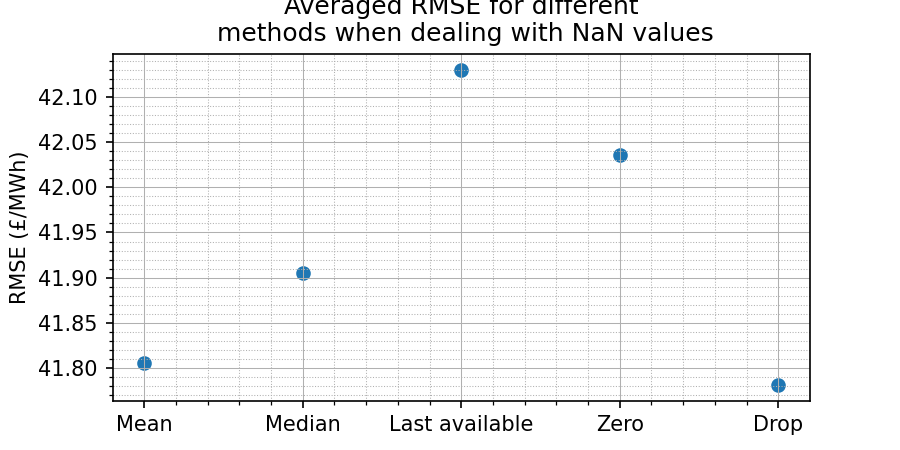

In [47]:
mse = results['Mean Scores']
rmse = mse ** 0.5

print(rmse)
plt.figure(figsize=(6,3))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE for different\n methods when dealing with NaN values')
plt.scatter(x = [1,2,3,4,5], y = rmse)
plt.ylabel('RMSE (£/MWh)')
plt.xticks([1,2,3,4,5], results['Methods'])
plt.savefig('fillnan.png')